In [1]:
import scipy
from numpy import fft
import numpy as np
from numpy import linspace
import math
from scipy import integrate
from matplotlib import pyplot as plt

In [2]:
eps=np.finfo(float).eps

In [3]:
# numerical grid
n = 2**13                   # number of grid points
twidth = 12.5e-12          # width of time window [s]
c = 299792458              # speed of light [m/s]
wavelength = 1550e-9        # reference wavelength [m]
w0 = (2*np.pi*c)/wavelength   # reference frequency [Hz]
dt = twidth/n
T = np.arange(-n/2, n/2-1)*dt # time grid

# === input pulse
power = 10                 # peak power of input [W]
t0 = 28.4e-15              # duration of input [s]
A = np.sqrt(power)*(1/(np.cosh(T/t0)))# input field [W^(1/2)]

# === fibre parameters
flength = 0.012             # fibre length [m]
# betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
betas = [-3.87856e-25,1.20677e-37,9.1831e-51]
gamma = 375.34              # nonlinear coefficient [1/W/m]
loss = 0                   # loss [dB/m]

# === Raman response
fr = 0.043                 # fractional Raman contribution
tau1 = 0.0122e-12; tau2 = 0.032e-12
RT = (tau1**2+tau2**2)/tau1/tau2**2*np.exp(-T/tau2)*np.sin(T/tau1)
RT = np.where(T < 0, RT, 0) # heaviside step function


# === simulation parameters
nsaves = 200     # number of length steps to save field at


In [4]:
n = len(T)
dT = T[1]-T[0]  # grid parameters
V = (np.arange(-n/2,n/2)*2*np.pi)/(n*dT)  # frequency grid
alpha = np.log(10**(loss/10))  # attenuation coefficient


B = 0
for i in range(len(betas)): # Taylor expansion of betas
    B += betas[i]/(math.factorial(i + 1)*V**(i + 1))
        
L = 1j*B - alpha /2  # linear operator

print(L)

[ 0.+1.88382567e-40j  0.+1.88428576e-40j  0.+1.88474607e-40j ...
 -0.-1.88520661e-40j -0.-1.88474607e-40j -0.-1.88428576e-40j]


In [5]:
# GNLSE Function
def gnlse(T, A, w0, gamma, betas, loss, fr, RT, flength, nsaves, printProgress = True):

    n = len(T)
    dT = T[1]-T[0]  # grid parameters
    V = (np.arange(-n/2,n/2)*2*np.pi)/(n*dT)  # frequency grid
    alpha = np.log(10**(loss/10))  # attenuation coefficient
    
    B = 0
    for i in range(len(betas)): # Taylor expansion of betas
        B += betas[i]/(math.factorial(i + 1)*V**(i + 1))
        
    L = 1j*B - alpha /2  # linear operator

    if abs(w0) > eps: # if w0>0 then include shock
        gamma = gamma/w0
        W=V+w0
    else: #set @ to 1 for no shock
        W = 1

    RW = n*fft.ifft(fft.fftshift(RT))  # frequency domain Raman
    L = fft.fftshift(L)
    W = fft.fftshift(W)  # shift to fft space

    def gnlse_rhs(z, AW):
        AT = fft.fft(AW*np.exp(L*z))  # time domain field
        AT = np.where(np.abs(AW) > eps, AW, 0)
        IT = np.abs(AT)**2  # time domain intensity
        if (len(RT) == 1) or fr < eps:  # no Raman case
            M = fft.ifft(AT*IT)  # response function
        else:
            RS = dT*fr*fft.fft(fft.ifft(IT)*RW)  # Raman convolution
            M = fft.ifft(AT*((1-fr)*IT+RS))  # response function

        R = 1j*gamma*W*M*np.exp(-L*z)  # full RHS of Eq. (3.13)
        

        return R

    # === setup and run the ODE integrator
    Z = np.linspace(0, flength, nsaves)# select output z points
    
    
    AW = np.zeros((nsaves, len(W)), dtype = 'complex_')# array for solution
    AW[0]=fft.fft(A)

    r = scipy.integrate.complex_ode(gnlse_rhs).set_integrator("dopri5")  # choice of method
    r.set_initial_value(fft.fft(A), 0) # initial values
    #help(r.integrate)
    for i in range(1, len(Z)):
        AW[i] = r.integrate(Z[i])  # get one more value, add it to the array
        if printProgress == True: 
            print(i , "/", len(Z))
        
        #AW.append(r.y)
        #if not r.successful():
        #    raise RuntimeError("Could not integrate")

    # === process output of integrator
    AT = []
    for i in range(len(AW)):
        AW[i] = AW[i] * np.exp(L*Z[i]) # change variables REMEMBER took ' out before Z
        AT.append(fft.ifft(AW[i]))           # time domain output
        AW[i] = fft.fftshift(AW[i])*dT*n  # scale

    W = V + w0  # the absolute frequency grid
    return {
            "AW" : AW, 
            "W" : W, 
            "AT": AT, 
            "Z" : Z
        }

In [6]:
# Multiple return values (tuple), explicitly unpack
#AW, W, AT = gnlse
# Multiple return values (tuple), keep tuple object, and index
#results = gnlse
#results[0] # AW
#results[1] # W
#results[2] # AT

In [7]:
# With dictonary
#results = gnlse
#results["AW"]

In [8]:
# propagate field
aaa = fft.fft(A)
results = gnlse(T, A, w0, gamma, betas, loss, fr, RT, flength, nsaves)


/var/folders/rs/4wwzr13n7gl2v6yf90jf926r0000gn/T/ipykernel_1651/2720096704.py:33: RuntimeWarning: overflow encountered in multiply
  M = fft.ifft(AT*((1-fr)*IT+RS))  # response function
/var/folders/rs/4wwzr13n7gl2v6yf90jf926r0000gn/T/ipykernel_1651/2720096704.py:33: RuntimeWarning: invalid value encountered in multiply
  M = fft.ifft(AT*((1-fr)*IT+RS))  # response function
/var/folders/rs/4wwzr13n7gl2v6yf90jf926r0000gn/T/ipykernel_1651/2720096704.py:28: RuntimeWarning: overflow encountered in square
  IT = np.abs(AT)**2  # time domain intensity
/Users/pablobedoyarios/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_ode.py:1181: UserWarning: dopri5: larger nsteps is needed
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


1 / 200


/Users/pablobedoyarios/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/_ode.py:1181: UserWarning: dopri5: step size becomes too small
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


2 / 200
3 / 200
4 / 200
5 / 200
6 / 200
7 / 200
8 / 200
9 / 200
10 / 200
11 / 200
12 / 200
13 / 200
14 / 200
15 / 200
16 / 200
17 / 200
18 / 200
19 / 200
20 / 200
21 / 200
22 / 200
23 / 200
24 / 200
25 / 200
26 / 200
27 / 200
28 / 200
29 / 200
30 / 200
31 / 200
32 / 200
33 / 200
34 / 200
35 / 200
36 / 200
37 / 200
38 / 200
39 / 200
40 / 200
41 / 200
42 / 200
43 / 200
44 / 200
45 / 200
46 / 200
47 / 200
48 / 200
49 / 200
50 / 200
51 / 200
52 / 200
53 / 200
54 / 200
55 / 200
56 / 200
57 / 200
58 / 200
59 / 200
60 / 200
61 / 200
62 / 200
63 / 200
64 / 200
65 / 200
66 / 200
67 / 200
68 / 200
69 / 200
70 / 200
71 / 200
72 / 200
73 / 200
74 / 200
75 / 200
76 / 200
77 / 200
78 / 200
79 / 200
80 / 200
81 / 200
82 / 200
83 / 200
84 / 200
85 / 200
86 / 200
87 / 200
88 / 200
89 / 200
90 / 200
91 / 200
92 / 200
93 / 200
94 / 200
95 / 200
96 / 200
97 / 200
98 / 200
99 / 200
100 / 200
101 / 200
102 / 200
103 / 200
104 / 200
105 / 200
106 / 200
107 / 200
108 / 200
109 / 200
110 / 200
111 / 200
112 / 

In [9]:
print("AW:", results["AW"][25], "A0: ", aaa)

AW: [-0.00101489+0.00090334j -0.00099678+0.00094044j -0.0009809 +0.00095638j
 ...  0.00410861-0.00321605j  0.00404599-0.00328441j
 -0.0010317 +0.00088633j] A0:  [ 184.90478215+2.77555756e-15j -184.85827965+7.09009207e-02j
  184.71888899-1.41694938e-01j ... -184.48696003-2.12275595e-01j
  184.71888899+1.41694938e-01j -184.85827965-7.09009207e-02j]


In [10]:
def compareArrays(a,b):
    arraysEqual = True
    for i in range(len(a)):
        if (a[i] - b[i]) > eps:
            arraysEqual = False
            print("Not equal value found at element ", i, a[i], b[i])
    if arraysEqual == True:
        print("The arrays are equal")
        
compareArrays(results["AW"][0],results["AW"][49])
            

Not equal value found at element  0 (7.455109484708201e-26-2.0016950090784355e-25j) (-0.0010148889744498817+0.000903336150167228j)
Not equal value found at element  1 (1.216774272871662e-25+1.1669256422741714e-26j) (-0.0009967846664587804+0.0009404410906065161j)
Not equal value found at element  2 (9.647208963100304e-27-6.870648293710535e-26j) (-0.0009808978208489573+0.0009563772562702995j)
Not equal value found at element  3 (6.467471335210257e-26-1.796544814727732e-26j) (-0.0009561533648820252+0.0009904832539025462j)
Not equal value found at element  4 (4.420358054494351e-26-1.2005187027883364e-25j) (-0.0009418375079757321+0.001004303916087121j)
Not equal value found at element  5 (6.288287449529279e-26+7.120423297002475e-27j) (-0.0009108586312609384+0.0010350800245385607j)
Not equal value found at element  6 (6.809240265092477e-26-1.581142041795952e-25j) (-0.0008985324749708392+0.0010459152254387j)
Not equal value found at element  7 (1.8626732695289656e-27+8.632445017739689e-26j) (

Not equal value found at element  294 (-2.0421553567951836e-26+3.458876438530774e-26j) (-0.0001465938672910429+1.2998580161668886e-05j)
Not equal value found at element  295 (-3.2004125632259143e-27+3.319763779953388e-26j) (-0.000126251737907251+1.1496013062595286e-05j)
Not equal value found at element  296 (6.90846762770452e-26+6.510103867759391e-26j) (-0.00014366283583576943+1.109649594249704e-05j)
Not equal value found at element  297 (5.2701722635528336e-27-1.637798522793715e-26j) (-0.00012340285326807072+9.606586109141482e-06j)
Not equal value found at element  298 (-6.655227735029593e-27+3.530182931865189e-26j) (-0.00014072879561472114+9.243833906346668e-06j)
Not equal value found at element  299 (5.757476240914709e-26+5.195558095885971e-26j) (-0.00012054858783593389+7.765453200558908e-06j)
Not equal value found at element  300 (4.09900063334894e-26+2.9389200523281995e-26j) (-0.00013779491585308304+7.4446352991801394e-06j)
Not equal value found at element  301 (9.175033086384811e

Not equal value found at element  419 (5.4552579749649316e-27-5.412452920091498e-26j) (-1.8299358016406803e-05-1.6281557087971025e-05j)
Not equal value found at element  420 (8.64047876254622e-27-4.1472975865660805e-26j) (-3.2621170035323676e-05-1.3897829698424051e-05j)
Not equal value found at element  421 (3.544934767879447e-26-1.515430266307135e-26j) (-1.7755277421884122e-05-1.617670153222275e-05j)
Not equal value found at element  422 (4.513853112888675e-26-2.944497757689455e-26j) (-3.204204923473101e-05-1.3779364029136231e-05j)
Not equal value found at element  423 (-2.3219075664665774e-26-6.736113173366172e-26j) (-1.722727142533374e-05-1.6070194586286188e-05j)
Not equal value found at element  424 (1.2060155864298885e-25-1.5298986095977254e-26j) (-3.147878683373884e-05-1.3659436258937327e-05j)
Not equal value found at element  425 (-2.1991270287182437e-26-1.0066903545658959e-25j) (-1.6714665009299993e-05-1.5961938956155068e-05j)
Not equal value found at element  426 (7.0778930908

Not equal value found at element  544 (4.441461308045399e-26-2.8122607615096294e-26j) (-1.4520538277417942e-05-5.766166033767998e-06j)
Not equal value found at element  545 (-1.3455793620845455e-25+2.5214204017382537e-26j) (-1.8984516981081977e-06-8.709005363510977e-06j)
Not equal value found at element  546 (3.8907959427509726e-26-7.946246371636921e-26j) (-1.4393081458637212e-05-5.662596193177357e-06j)
Not equal value found at element  547 (-3.2577069711551763e-26+1.0871666898489377e-26j) (-1.7995711218423506e-06-8.619889733902295e-06j)
Not equal value found at element  548 (-9.605765192355933e-27-2.1816218418067706e-26j) (-1.4268057038960223e-05-5.5604827231893945e-06j)
Not equal value found at element  549 (5.325351898663991e-26-1.5559256881900205e-26j) (-1.7030886718970036e-06-8.532223434400863e-06j)
Not equal value found at element  550 (5.928775575146711e-27+8.609826908503216e-27j) (-1.414539415482758e-05-5.459814653665138e-06j)
Not equal value found at element  551 (2.1763142940

Not equal value found at element  742 (-1.992112805787638e-26-7.396645347909601e-26j) (-7.834320341356423e-06-2.321502421802808e-07j)
Not equal value found at element  744 (8.679125424757405e-27-4.926354832129922e-26j) (-7.796782995940562e-06-2.0508588016962714e-07j)
Not equal value found at element  746 (4.214857176725578e-26+1.9206383319769396e-26j) (-7.759530867204959e-06-1.7833616506150556e-07j)
Not equal value found at element  748 (2.1358829616154156e-26+7.992557118546361e-27j) (-7.722559391225081e-06-1.5189679669182356e-07j)
Not equal value found at element  750 (7.574970567245852e-26-3.5223535215861306e-26j) (-7.68586409913625e-06-1.257635601570544e-07j)
Not equal value found at element  752 (6.666933047026398e-26-2.0753778936930022e-26j) (-7.649440614839932e-06-9.993232381211705e-08j)
Not equal value found at element  754 (-7.551514885711952e-26+2.938157507616442e-26j) (-7.613284652773137e-06-7.439903731651783e-08j)
Not equal value found at element  756 (5.463238466098403e-26-

Not equal value found at element  1092 (4.058208655970405e-26-8.292652755573594e-26j) (-3.536240113320504e-06+1.7417659272807444e-06j)
Not equal value found at element  1094 (-2.076170151907587e-25-1.0249474239038793e-26j) (-3.518737490287872e-06+1.7434011798657312e-06j)
Not equal value found at element  1096 (-5.180418370234128e-26+1.0751616904399624e-25j) (-3.501281792127348e-06+1.7449652806402488e-06j)
Not equal value found at element  1098 (1.030997779930532e-25-3.367647251843853e-26j) (-3.4838727744760896e-06+1.746458572289594e-06j)
Not equal value found at element  1100 (3.8254785251146963e-26-6.228574453891763e-26j) (-3.4665101965776806e-06+1.7478813938956124e-06j)
Not equal value found at element  1102 (-7.615894615129969e-26+8.016099033595477e-26j) (-3.4491938212314537e-06+1.7492340809854715e-06j)
Not equal value found at element  1104 (3.3576349709201976e-27+1.183801401105169e-25j) (-3.431923414742218e-06+1.7505169655796393e-06j)
Not equal value found at element  1106 (-1.424

Not equal value found at element  1330 (7.058553978967285e-26-1.3090998066038368e-26j) (-1.7375606686122815e-06+1.5088641567377744e-06j)
Not equal value found at element  1332 (-1.4427652880106538e-26-6.632694253301167e-26j) (-1.7246228626674877e-06+1.5037344502676285e-06j)
Not equal value found at element  1334 (-5.502356494680047e-26+2.6959106998649075e-26j) (-1.711718925109587e-06+1.4985581299334811e-06j)
Not equal value found at element  1336 (4.6094228198035716e-27-6.283912590135403e-26j) (-1.6988488303304168e-06+1.493335315523933e-06j)
Not equal value found at element  1338 (-3.642645980189871e-27-1.2796850263739805e-25j) (-1.686012553554138e-06+1.4880661259657453e-06j)
Not equal value found at element  1340 (5.478313106403516e-26+1.536925092715573e-26j) (-1.6732100708286797e-06+1.4827506793329165e-06j)
Not equal value found at element  1342 (1.4859997078043351e-25-1.9637631189452425e-26j) (-1.6604413590170809e-06+1.4773890928556266e-06j)
Not equal value found at element  1344 (2

Not equal value found at element  1743 (1.2711824314472203e-26-7.150025759340232e-26j) (-1.3010101393574906e-07+3.991378108563537e-07j)
Not equal value found at element  1745 (2.892785459824086e-26+1.1962686986314678e-26j) (-1.3359380234744065e-07+4.1171083669172076e-07j)
Not equal value found at element  1747 (8.955449204747005e-26-1.1269319886859477e-26j) (-1.3705842545000054e-07+4.2431097487157896e-07j)
Not equal value found at element  1749 (-3.740564755442027e-26-5.333448506178082e-26j) (-1.404947736716939e-07+4.3693823956709725e-07j)
Not equal value found at element  1751 (3.321986833506417e-26-2.9904767191919363e-26j) (-1.439027373494029e-07+4.4959264477425916e-07j)
Not equal value found at element  1753 (5.713906420835814e-27-7.067249714061309e-26j) (-1.4728220672703126e-07+4.6227420431492666e-07j)
Not equal value found at element  1755 (-4.726040845868699e-26-1.4249122071858883e-26j) (-1.5063307195398244e-07+4.749829318378012e-07j)
Not equal value found at element  1757 (2.549

Not equal value found at element  2360 (-3.812231460533341e-26+1.2606774297152376e-25j) (-2.594462379310123e-07-5.796183899729035e-06j)
Not equal value found at element  2362 (-9.607394366696216e-26-7.017025546456153e-26j) (-2.697929003903943e-07-5.8176968981762055e-06j)
Not equal value found at element  2364 (4.971214994792457e-28+3.941984370980302e-26j) (-2.802098308937209e-07-5.839234118534835e-06j)
Not equal value found at element  2366 (-1.3122177416033226e-25-4.6540010986163747e-26j) (-2.9069719504563207e-07-5.860795548662894e-06j)
Not equal value found at element  2368 (-6.758061278878663e-27-5.325851093673513e-26j) (-3.012551590989865e-07-5.8823811765208136e-06j)
Not equal value found at element  2370 (-6.327172688781378e-26+8.101131302467775e-27j) (-3.1188388995805105e-07-5.903990990171227e-06j)
Not equal value found at element  2372 (1.2627149511834244e-26-6.532586156351795e-26j) (-3.225835551818856e-07-5.925624977779899e-06j)
Not equal value found at element  2374 (-3.504006

Not equal value found at element  2858 (-3.6812997768386125e-21-1.890571677505518e-21j) (-5.563257487711666e-06-1.1888771633205632e-05j)
Not equal value found at element  2860 (-3.851596570098916e-21-1.9743965670087273e-21j) (-5.598634611647242e-06-1.1916259460656398e-05j)
Not equal value found at element  2862 (-4.0298664109085085e-21-2.0618210622302383e-21j) (-5.63415704913872e-06-1.1943772569554563e-05j)
Not equal value found at element  2864 (-4.216400659002594e-21-2.15319636727808e-21j) (-5.669825322298108e-06-1.1971310982629208e-05j)
Not equal value found at element  2866 (-4.411669170362596e-21-2.2485525156050396e-21j) (-5.705639955964289e-06-1.1998874722708143e-05j)
Not equal value found at element  2868 (-4.615742256915853e-21-2.348276983520209e-21j) (-5.741601477718148e-06-1.2026463812715329e-05j)
Not equal value found at element  2870 (-4.8293163376312075e-21-2.4522022359819698e-21j) (-5.777710417898381e-06-1.2054078275668113e-05j)
Not equal value found at element  2872 (-5.

Not equal value found at element  3108 (-1.0468008285259028e-18-4.1635375080497256e-19j) (-1.130762942002109e-05-1.5527591650674656e-05j)
Not equal value found at element  3110 (-1.0951556024431573e-18-4.346137465712031e-19j) (-1.1366236196508789e-05-1.5558386131766995e-05j)
Not equal value found at element  3112 (-1.1457432086546002e-18-4.536724739004028e-19j) (-1.1425079564610017e-05-1.558920699140683e-05j)
Not equal value found at element  3114 (-1.1986667083967141e-18-4.735649202241572e-19j) (-1.1484160496783861e-05-1.562005417700629e-05j)
Not equal value found at element  3116 (-1.2540338982942094e-18-4.943273741453293e-19j) (-1.1543479969378376e-05-1.5650927633438706e-05j)
Not equal value found at element  3118 (-1.3119578954491844e-18-5.159979584282658e-19j) (-1.1603038962607028e-05-1.568182730296777e-05j)
Not equal value found at element  3120 (-1.3725562862535409e-18-5.386162891893214e-19j) (-1.1662838460525805e-05-1.5712753125173924e-05j)
Not equal value found at element  312

Not equal value found at element  3430 (-1.4916100102583247e-15-3.8891341509015016e-16j) (-2.4461641848589264e-05-2.055692792332387e-05j)
Not equal value found at element  3432 (-1.5603477743989594e-15-4.0555765446293177e-16j) (-2.4569311333806888e-05-2.0582713195163327e-05j)
Not equal value found at element  3434 (-1.632252150954489e-15-4.229102810898627e-16j) (-2.4677262958550237e-05-2.060821783055174e-05j)
Not equal value found at element  3436 (-1.7074689726390816e-15-4.4100125072235775e-16j) (-2.478549285641185e-05-2.0633431130812475e-05j)
Not equal value found at element  3438 (-1.7861507860160385e-15-4.598617764668454e-16j) (-2.4893997001647046e-05-2.065834196959222e-05j)
Not equal value found at element  3440 (-1.868457160909148e-15-4.795243809836986e-16j) (-2.500277120541252e-05-2.0682938773742848e-05j)
Not equal value found at element  3442 (-1.954555013041192e-15-5.000229509241502e-16j) (-2.5111811112077467e-05-2.070720950338134e-05j)
Not equal value found at element  3444 (

Not equal value found at element  3608 (-8.203189614485665e-14-1.5503038550550635e-14j) (-3.496284386427147e-05-1.7828603255440504e-05j)
Not equal value found at element  3610 (-8.580744476297796e-14-1.6148409119718823e-14j) (-3.513402849872172e-05-1.7622073539014964e-05j)
Not equal value found at element  3612 (-8.975670972940188e-14-1.6820356237110204e-14j) (-3.531119890488118e-05-1.7406177689019056e-05j)
Not equal value found at element  3614 (-9.388768138635108e-14-1.7519959701320788e-14j) (-3.5494854074761905e-05-1.7180691297310596e-05j)
Not equal value found at element  3616 (-9.820871748985029e-14-1.8248342433979394e-14j) (-3.5685525823835335e-05-1.694540659003176e-05j)
Not equal value found at element  3618 (-1.0272856009777959e-13-1.900667216476197e-14j) (-3.58837802934242e-05-1.670013545075977e-05j)
Not equal value found at element  3620 (-1.0745635323657475e-13-1.979616317761208e-14j) (-3.6090219396861615e-05-1.644471260194805e-05j)
Not equal value found at element  3622 (-1

Not equal value found at element  3858 (-2.2631846196117498e-11-2.062907416873749e-12j) (-3.963045221818462e-05+0.00021150311413628583j)
Not equal value found at element  3860 (-2.3671655226418698e-11-2.139378944289227e-12j) (-4.3250998776340815e-05+0.00022779149001037868j)
Not equal value found at element  3862 (-2.4759217810694865e-11-2.2185236447568456e-12j) (-4.6880243952678105e-05+0.0002443441545082757j)
Not equal value found at element  3864 (-2.5896725613031386e-11-2.3004257482522373e-12j) (-5.046157050693427e-05+0.00026106825140282145j)
Not equal value found at element  3866 (-2.7086470744253822e-11-2.3851715788170707e-12j) (-5.393865842399811e-05+0.00027786799773030414j)
Not equal value found at element  3868 (-2.833085034832602e-11-2.472849568510579e-12j) (-5.7257054155863324e-05+0.00029464740954551115j)
Not equal value found at element  3870 (-2.963237139582116e-11-2.5635502681245475e-12j) (-6.036601099868391e-05+0.0003113130650453618j)
Not equal value found at element  3872

Not equal value found at element  4080 (-2.1861242520501547e-09-1.2577196307452625e-11j) (-0.0010732591418721894+0.0009692200467700884j)
Not equal value found at element  4082 (-2.2161458714172235e-09-1.1049897289818713e-11j) (-0.0010711157695692214+0.001039463084018731j)
Not equal value found at element  4084 (-2.242427103921597e-09-9.460771268336542e-12j) (-0.001026283355908712+0.0010798285497913126j)
Not equal value found at element  4086 (-2.2647260426144772e-09-7.817589380066464e-12j) (-0.0009414969333567836+0.0010899205585424444j)
Not equal value found at element  4088 (-2.2828319755520838e-09-6.128948573760593e-12j) (-0.000821943059121115+0.0010723606232255307j)
Not equal value found at element  4090 (-2.2965700887437503e-09-4.404161008291695e-12j) (-0.0006747806108322919+0.0010322478004680944j)
Not equal value found at element  4092 (-2.3058054956222654e-09-2.653121036193243e-12j) (-0.0005085115821688662+0.0009763286924640824j)
Not equal value found at element  4094 (-2.3104464

Not equal value found at element  4397 (5.25444048949834e-12-6.113567482826152e-13j) (-0.00023194841735533304-0.00013831901184171617j)
Not equal value found at element  4399 (5.0235212528142965e-12-5.883951592773522e-13j) (-0.0002347625870927128-0.00013521051947181726j)
Not equal value found at element  4401 (4.802747415578238e-12-5.662713435422843e-13j) (-0.0002369996150523202-0.0001323453264114947j)
Not equal value found at element  4403 (4.5916733725828865e-12-5.449559964604223e-13j) (-0.00023869776642592564-0.0001296734847236035j)
Not equal value found at element  4405 (4.389873084217805e-12-5.244207718424837e-13j) (-0.0002398932414839392-0.0001271512421289268j)
Not equal value found at element  4407 (4.196939217717991e-12-5.046382542517514e-13j) (-0.0002406201887404913-0.00012474069719983636j)
Not equal value found at element  4409 (4.012482326082079e-12-4.85581931911615e-13j) (-0.00024091077082449445-0.00012240940906401714j)
Not equal value found at element  4411 (3.8361300630084

Not equal value found at element  4565 (1.2024947370160653e-13-2.1914631610305165e-14j) (-7.377373420869193e-05+5.445875348262492e-06j)
Not equal value found at element  4567 (1.1495899217352045e-13-2.1041602838452557e-14j) (-7.340595432311247e-05+6.030040626122969e-06j)
Not equal value found at element  4569 (1.0990120320600373e-13-2.0202986803019968e-14j) (-7.3061460039608e-05+6.600094989338877e-06j)
Not equal value found at element  4571 (1.0506587514796821e-13-1.9397444750418843e-14j) (-7.273881797464522e-05+7.156289331760448e-06j)
Not equal value found at element  4573 (1.0044322611275574e-13-1.862368914389167e-14j) (-7.24366556331878e-05+7.69886267709029e-06j)
Not equal value found at element  4575 (9.602390421397487e-14-1.7880481746337854e-14j) (-7.215366013962618e-05+8.228043839191071e-06j)
Not equal value found at element  4577 (9.179896866730804e-14-1.7166631773615485e-14j) (-7.188857685607605e-05+8.74405302138647e-06j)
Not equal value found at element  4579 (8.77598717246658

Not equal value found at element  4921 (3.9598382401543423e-17-1.2982252622727015e-17j) (-5.034749611797119e-05+2.7709632415558664e-05j)
Not equal value found at element  4923 (3.785198791524051e-17-1.2441865244670207e-17j) (-5.022049012893658e-05+2.7733731725050282e-05j)
Not equal value found at element  4925 (3.618259042498488e-17-1.1923899484627835e-17j) (-5.009376619147187e-05+2.7757758447708784e-05j)
Not equal value found at element  4927 (3.458679634968411e-17-1.1427428506614701e-17j) (-4.996732511177006e-05+2.778171362106848e-05j)
Not equal value found at element  4929 (3.30613614399402e-17-1.0951563399145144e-17j) (-4.984116762555207e-05+2.7805598238017232e-05j)
Not equal value found at element  4931 (3.160318452961467e-17-1.049545203019012e-17j) (-4.971529440043107e-05+2.7829413248462597e-05j)
Not equal value found at element  4933 (3.020930110276173e-17-1.0058277185081249e-17j) (-4.9589706038200603e-05+2.7853159560946482e-05j)
Not equal value found at element  4935 (2.8876877

Not equal value found at element  5143 (2.63974936859528e-19-1.122148246558543e-19j) (-3.791799895410174e-05+3.003254135814239e-05j)
Not equal value found at element  5145 (2.5231398117281486e-19-1.0748629216772704e-19j) (-3.781973112025083e-05+3.005046261215596e-05j)
Not equal value found at element  5147 (2.411682621967381e-19-1.0295667835432484e-19j) (-3.7721671494006585e-05+3.0068329569071632e-05j)
Not equal value found at element  5149 (2.305147130559912e-19-9.861794156328061e-20j) (-3.762381908845225e-05+3.0086142177118036e-05j)
Not equal value found at element  5151 (2.2033133237420373e-19-9.446134016573432e-20j) (-3.752617291961095e-05+3.0103900384646716e-05j)
Not equal value found at element  5153 (2.1059772808314088e-19-9.047953988144536e-20j) (-3.742873200650867e-05+3.0121604140148575e-05j)
Not equal value found at element  5155 (2.0129429021168694e-19-8.666528815214454e-20j) (-3.733149537123444e-05+3.0139253392271027e-05j)
Not equal value found at element  5157 (1.924014411

Not equal value found at element  5727 (4.377604104430403e-25-4.249359432440721e-25j) (-1.5089711428133395e-05+3.28187694399384e-05j)
Not equal value found at element  5729 (5.127420427862642e-25-1.9116270186716222e-25j) (-1.5024721044729553e-05+3.281953771106688e-05j)
Not equal value found at element  5731 (5.381113031448999e-25-4.681712974437026e-25j) (-1.4959790059854695e-05+3.282024399201518e-05j)
Not equal value found at element  5733 (3.6369101061501227e-25-2.1651793046315554e-25j) (-1.4894918293188037e-05+3.282088825772844e-05j)
Not equal value found at element  5735 (5.408772291889279e-25-2.39920565559977e-25j) (-1.4830105565662323e-05+3.282147048305867e-05j)
Not equal value found at element  5737 (3.3636237323261673e-25-3.395494728711762e-25j) (-1.4765351699458576e-05+3.282199064276037e-05j)
Not equal value found at element  5739 (3.281738875947703e-25-2.1483164528628307e-25j) (-1.4700656517997216e-05+3.2822448711492386e-05j)
Not equal value found at element  5741 (3.318279748

Not equal value found at element  6111 (-1.866980407866563e-25-1.1323129700138658e-25j) (-3.5489776332594927e-06+3.179414244559025e-05j)
Not equal value found at element  6113 (1.2695312725254883e-25+6.979514589145504e-26j) (-3.493257215030782e-06+3.1782406475232306e-05j)
Not equal value found at element  6115 (-7.518474207215899e-26+8.843410073817263e-26j) (-3.4375788849128093e-06+3.1770601231685066e-05j)
Not equal value found at element  6117 (-5.0947420515677506e-26+3.183678857277128e-26j) (-3.381942621902001e-06+3.175872665864216e-05j)
Not equal value found at element  6119 (-5.760804861176575e-26-4.241650626365476e-26j) (-3.3263484055523197e-06+3.174678269952918e-05j)
Not equal value found at element  6121 (5.612609004369715e-26-4.777955660238484e-26j) (-3.270796215972247e-06+3.173476929749569e-05j)
Not equal value found at element  6123 (-2.995617661082049e-26+1.41816780697345e-25j) (-3.2152860338250253e-06+3.172268639541798e-05j)
Not equal value found at element  6125 (-3.226702

Not equal value found at element  6760 (4.994621491949372e-27-2.0415143576116127e-26j) (-5.49590813925237e-06-3.363324135357046e-05j)
Not equal value found at element  6762 (-1.8935901323949127e-26+7.652895428052184e-26j) (-5.542927181932546e-06-3.363829111377272e-05j)
Not equal value found at element  6764 (4.0872116174852995e-26-2.8248566347143056e-26j) (-5.58995135956123e-06-3.3643368547375984e-05j)
Not equal value found at element  6766 (9.184741912725591e-26-5.136663230703715e-27j) (-5.636980751262305e-06-3.3648474131687965e-05j)
Not equal value found at element  6768 (-7.6685168936367e-26+1.0082981228152221e-25j) (-5.68401543630648e-06-3.365360834827963e-05j)
Not equal value found at element  6770 (-7.279273950357382e-26-6.632565621941361e-26j) (-5.731055494111983e-06-3.3658771683028976e-05j)
Not equal value found at element  6772 (3.566410075785886e-27+3.9052920366240035e-26j) (-5.778101004238686e-06-3.366396462616743e-05j)
Not equal value found at element  6774 (-1.441513134970

Not equal value found at element  7260 (-3.3165621867468e-26+9.860574515536761e-26j) (-1.7545383250475073e-05-3.8360217580131665e-05j)
Not equal value found at element  7262 (-6.023199232159945e-26+4.797531588271303e-26j) (-1.7593769428496244e-05-3.841491270900727e-05j)
Not equal value found at element  7264 (-2.0620618876476335e-26+2.652050587895613e-26j) (-1.764210850748612e-05-3.847024736370777e-05j)
Not equal value found at element  7266 (-4.91859154810591e-26-6.257437840947647e-26j) (-1.7690398584956597e-05-3.8526229955463624e-05j)
Not equal value found at element  7268 (-2.995684585221586e-26+2.83304015745799e-26j) (-1.7738637706264177e-05-3.858286902386848e-05j)
Not equal value found at element  7270 (-7.352589413531718e-26-1.351485828617437e-26j) (-1.7786823863216586e-05-3.8640173239202635e-05j)
Not equal value found at element  7272 (-1.5216618069980524e-25-4.01922076472422e-27j) (-1.783495499264795e-05-3.869815140480154e-05j)
Not equal value found at element  7274 (-1.8142067

Not equal value found at element  7490 (1.0951115166908328e-25+1.6386985687271964e-26j) (-2.1555158657737945e-05-5.2373223119780343e-05j)
Not equal value found at element  7492 (1.6970823214995699e-25+1.0098737786102316e-25j) (-2.155055653550234e-05-5.261688820083987e-05j)
Not equal value found at element  7494 (-9.93018960866481e-26+1.4260535750773436e-25j) (-2.1544311388702972e-05-5.28642167888121e-05j)
Not equal value found at element  7496 (-1.4924756934549624e-25+8.373311379379537e-26j) (-2.1536372658338878e-05-5.311527510601524e-05j)
Not equal value found at element  7498 (-6.675912611534994e-26-1.048990474740016e-25j) (-2.1526688111401237e-05-5.337013076558031e-05j)
Not equal value found at element  7500 (1.6691601221892788e-26-1.4254544562950652e-25j) (-2.151520377944172e-05-5.362885279904391e-05j)
Not equal value found at element  7502 (3.966139443105195e-26-5.805014547410219e-26j) (-2.1501863894388872e-05-5.3891511683885505e-05j)
Not equal value found at element  7504 (7.2297

In [11]:
frequencies = results["W"]


In [12]:
finalAWConjugate = np.abs(results["AW"][nsaves - 1]) ** 2

In [13]:
AConjugate = np.abs(fft.ifft(fft.fftshift(A)))**2 

In [14]:
def toDecibles(from_):
    return 10 * np.log10(from_)

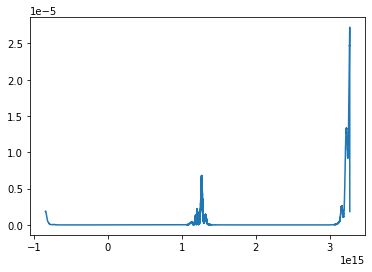

In [15]:
plt.plot(frequencies, finalAWConjugate)

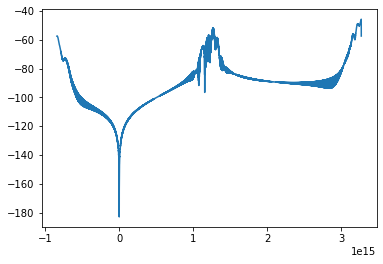

In [16]:
plt.plot(frequencies, toDecibles(finalAWConjugate))

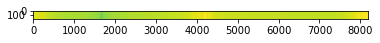

In [17]:
plt.imshow(toDecibles(np.abs(results["AW"]) ** 2))